In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import transforms, datasets, models
import urllib.request
import tarfile
import os
import pandas as pd
from PIL import Image, ImageFilter
from tqdm import tqdm

import os
import urllib.request
import threading

# 다운로드 받을 경로 설정 (예: 현재 디렉터리 또는 지정된 경로)
download_path = 'DATA'  # 원하는 경로로 변경 가능

# 다운로드 경로가 존재하지 않으면 생성
if not os.path.exists(download_path):
    os.makedirs(download_path)

# 파일 URL 리스트
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
    'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
    'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
    'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
    'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
    'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
    'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
    'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

# 파일 다운로드 함수
def download_file(url, download_dir, idx):
    fn = os.path.join(download_dir, f'images_{idx+1:02d}.tar.gz')
    print(f'Downloading {fn}...')
    urllib.request.urlretrieve(url, fn)  # 파일 다운로드
    print(f'{fn} download complete.')

# 다운로드 스레드 생성
threads = []
for idx, link in enumerate(links):
    thread = threading.Thread(target=download_file, args=(link, download_path, idx))
    threads.append(thread)
    thread.start()

# 모든 스레드가 끝날 때까지 기다리기
for thread in threads:
    thread.join()

print("All downloads complete. Files are saved in", download_path)

import os
import tarfile
import shutil

# tar 파일들이 저장된 경로 (다운로드 경로와 동일하게 설정)
tar_dir = 'DATA'  # 원본 tar 파일들이 저장된 경로
extract_dir = 'DATA'  # 압축 해제할 경로

# Loop through each downloaded tar file and extract it
for idx in range(1, len(links) + 1):
    tar_path = os.path.join(tar_dir, f'images_{idx:02d}.tar.gz')

    # Extract the tar file into the specified directory
    print(f'Extracting {tar_path} to {extract_dir}...')
    with tarfile.open(tar_path, 'r:gz') as tar:
        tar.extractall(path=extract_dir)

    # Delete the original tar.gz file after extraction
    os.remove(tar_path)
    print(f'Deleted {tar_path} after extraction.')

print("Extraction complete.")



DATA/images_01.tar.gz download complete.
DATA/images_12.tar.gz download complete.
DATA/images_04.tar.gz download complete.
DATA/images_05.tar.gz download complete.
DATA/images_06.tar.gz download complete.
DATA/images_03.tar.gz download complete.
DATA/images_07.tar.gz download complete.
DATA/images_02.tar.gz download complete.
DATA/images_10.tar.gz download complete.
DATA/images_11.tar.gz download complete.
DATA/images_09.tar.gz download complete.
DATA/images_08.tar.gz download complete.
All downloads complete. Files are saved in DATA
Extracting DATA/images_01.tar.gz to DATA...
Deleted DATA/images_01.tar.gz after extraction.
Extracting DATA/images_02.tar.gz to DATA...
Deleted DATA/images_02.tar.gz after extraction.
Extracting DATA/images_03.tar.gz to DATA...
Deleted DATA/images_03.tar.gz after extraction.
Extracting DATA/images_04.tar.gz to DATA...
Deleted DATA/images_04.tar.gz after extraction.
Extracting DATA/images_05.tar.gz to DATA...
Deleted DATA/images_05.tar.gz after extraction.


Train data before sampling: (89826, 12)
Test data: (22294, 12)
Train data after sampling and filtering: (43243, 12)
Class distribution in the full dataset:


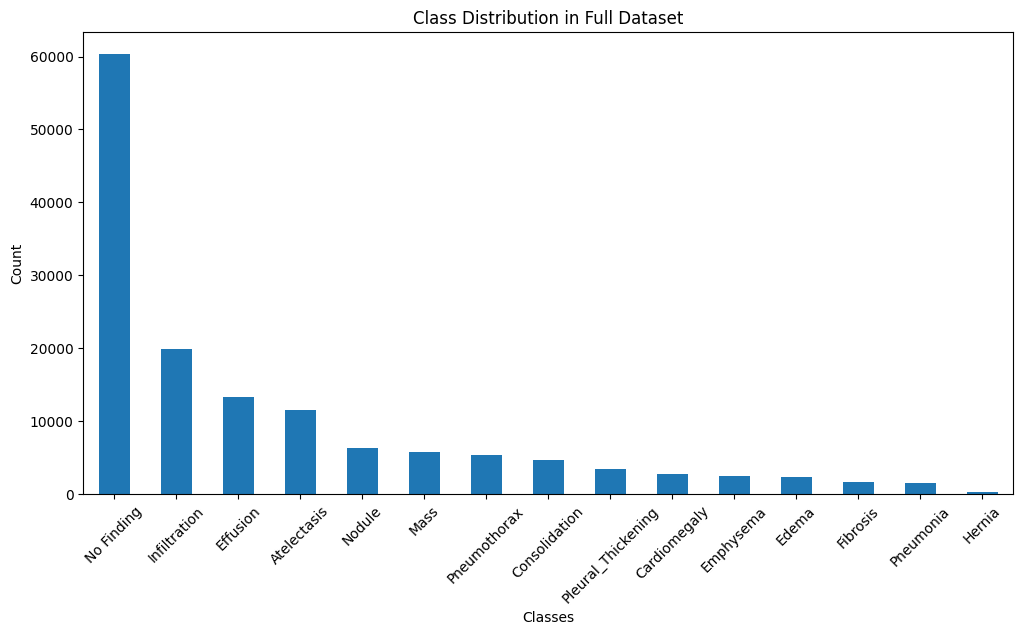

Class distribution in the train set before sampling:


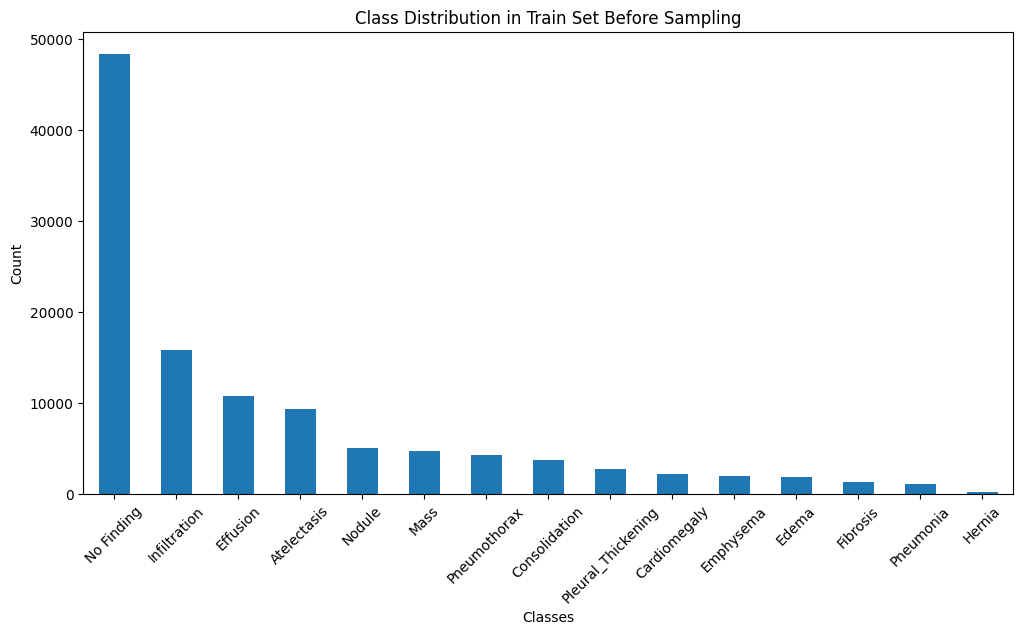

Class distribution in the train set after sampling:


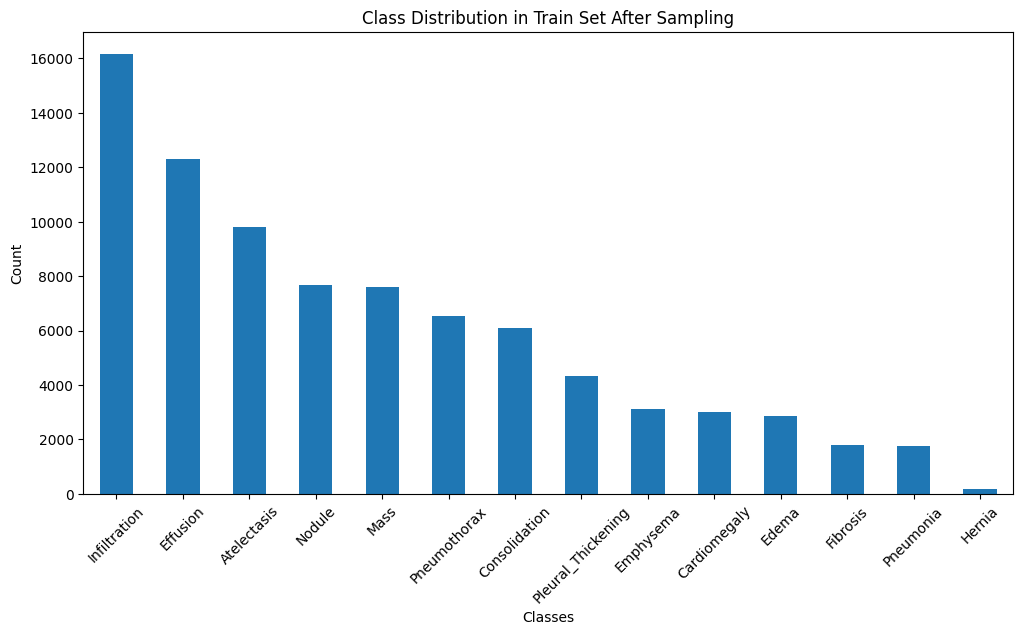

Class distribution in the test set:


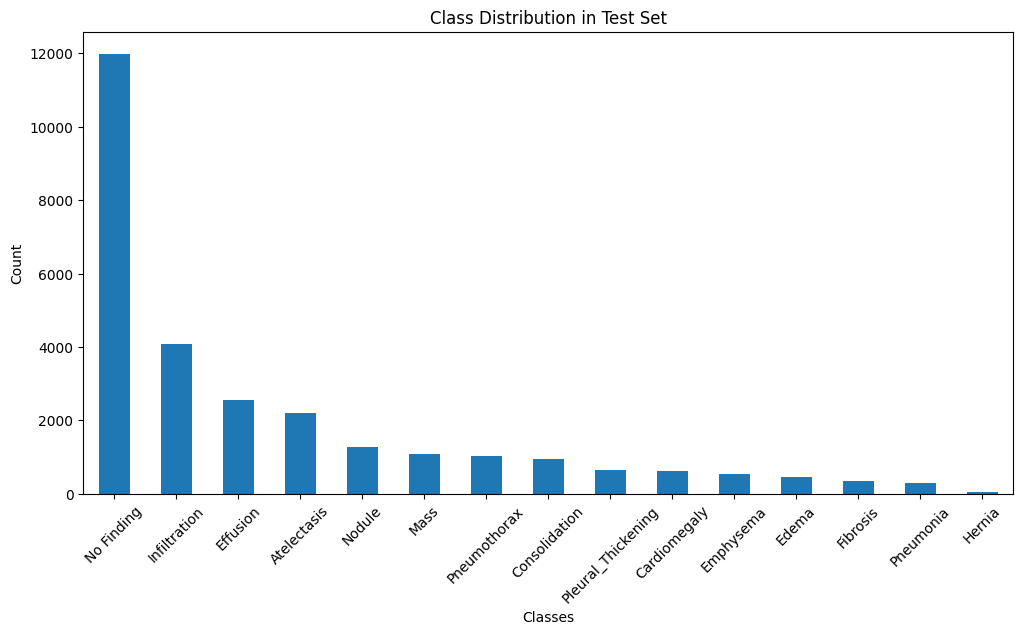

In [2]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import torch
import os
import matplotlib.pyplot as plt # This line imports the necessary module

# Load CSV file
csv_file_path = './Data_Entry_2017_v2020.csv'
df = pd.read_csv(csv_file_path)

# Define class names
class_names = [
    'Atelectasis', 'Consolidation', 'Effusion', 'Infiltration', 'Mass',
    'Nodule', 'Pneumothorax', 'Pleural_Thickening', 'Hernia', 'Pneumonia',
    'Fibrosis', 'Edema', 'Cardiomegaly', 'Emphysema'
]

# Get labels function
def get_labels(diseases):
    labels = torch.zeros(len(class_names))
    if diseases != 'No Finding':
        for label_name in diseases.split('|'):
            if label_name in class_names:
                labels[class_names.index(label_name)] = 1
    return labels

# Dataset class
class CXR14dataset(Dataset):
    def __init__(self, img_dirs, df, augment=None):
        self.img_dirs = img_dirs
        self.df = df
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5123], [0.2307])
        ])
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        diseases = self.df.iloc[idx, 1]
        label = get_labels(diseases)

        image = None
        for img_dir in self.img_dirs:
            img_path = os.path.join(img_dir, img_name)
            if os.path.exists(img_path):
                image = Image.open(img_path).convert("RGB")
                break

        if image is None:
            raise FileNotFoundError(f"Image {img_name} not found in provided directories.")

        if self.augment:
            image = self.augment(image)
        else:
            image = self.transform(image)

        return image, label

# Define sampling ratios for each class
sampling_ratios = {
    'Atelectasis': 0.4,
    'Cardiomegaly': 1,
    'Consolidation': 1,
    'Edema': 1,
    'Effusion': 0.4,
    'Emphysema': 1,
    'Fibrosis': 1,
    'Hernia': 1,
    'Infiltration': 0.5,
    'Mass': 1,
    'Nodule': 1,
    'Pneumonia': 1,
    'Pleural_Thickening': 1,
    'Pneumothorax': 1,
    'No Finding': 0.6
}

# Sampling function
def apply_class_sampling(df, class_names, sampling_ratios):
    sampled_df = pd.DataFrame()
    for class_name in class_names:
        if class_name == 'No Finding':
            no_finding_df = df[df['Finding Labels'] == 'No Finding']
            sample_size = int(len(no_finding_df) * sampling_ratios[class_name])
            sampled_no_finding_df = no_finding_df.sample(n=sample_size, random_state=42, replace=False)
            sampled_df = pd.concat([sampled_df, sampled_no_finding_df], axis=0)
        else:
            class_df = df[df['Finding Labels'].str.contains(class_name, na=False)]
            sample_size = int(len(class_df) * sampling_ratios[class_name])
            sampled_class_df = class_df.sample(n=min(sample_size, len(class_df)), random_state=42, replace=False)
            sampled_df = pd.concat([sampled_df, sampled_class_df], axis=0)
    return sampled_df

# Create combined labels column for stratification
df['combined_labels'] = df['Finding Labels'].apply(
    lambda x: '|'.join(sorted([label for label in x.split('|') if label in class_names]))
)

# Split data into train and test sets
group_split = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_indices, test_indices = next(group_split.split(df, groups=df['Patient ID']))
train_df = df.iloc[train_indices]
test_df = df.iloc[test_indices]

print(f"Train data before sampling: {train_df.shape}")
print(f"Test data: {test_df.shape}")

# Apply sampling only to training data
train_df_sampled = apply_class_sampling(train_df, class_names, sampling_ratios)

# Filter out rare classes
train_class_counts = train_df_sampled['combined_labels'].value_counts()
rare_classes = train_class_counts[train_class_counts < 10].index
train_df_filtered = train_df_sampled[~train_df_sampled['combined_labels'].isin(rare_classes)]

print(f"Train data after sampling and filtering: {train_df_filtered.shape}")

# Image directories
img_dirs = ['./DATA/images']

# Create datasets and dataloaders
batch_size = 64
num_cores = os.cpu_count()

train_dataset = CXR14dataset(img_dirs=img_dirs, df=train_df_filtered)
test_dataset = CXR14dataset(img_dirs=img_dirs, df=test_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_cores, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_cores, pin_memory=True, persistent_workers=True)



# Function to visualize class distribution
def plot_class_distribution(df, title):
    class_counts = df['Finding Labels'].str.split('|').explode().value_counts()
    plt.figure(figsize=(12, 6))
    class_counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Plot class distributions
print("Class distribution in the full dataset:")
plot_class_distribution(df, "Class Distribution in Full Dataset")

print("Class distribution in the train set before sampling:")
plot_class_distribution(train_df, "Class Distribution in Train Set Before Sampling")

print("Class distribution in the train set after sampling:")
plot_class_distribution(train_df_filtered, "Class Distribution in Train Set After Sampling")

print("Class distribution in the test set:")
plot_class_distribution(test_df, "Class Distribution in Test Set")


In [3]:
import fastai
from fastai.vision.all import *

SEED = 64
item_transforms = [
    Resize((224, 224)),
]

batch_transforms = [
    #Flip(),
    #Rotate(),
    Normalize.from_stats(*imagenet_stats),
]


def get_x(row):
    base_dir = '/content/DATA/images'  # Base directory where the images are stored
    image_idx = row['Image Index']  # Column in the CSV that contains the image index
    return f"{base_dir}/{image_idx}"  # Construct the full path to the image

def get_y(row):
    diseases = row['Finding Labels']  # Column containing the labels
    label = [0] * len(class_names)  # Initialize a list of 0s for all classes
    for label_name in diseases.split('|'):
        if label_name in class_names:
            label[class_names.index(label_name)] = 1  # Set 1 for present classes
    return label


dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True,vocab=class_names)),
                   splitter=RandomSplitter(valid_pct=0.125, seed=SEED),
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=item_transforms,
                   batch_tfms=batch_transforms
                  )
dls = dblock.dataloaders(train_df_filtered, bs=16)


from fastai.vision.all import *

cbs=[
    SaveModelCallback(monitor='valid_loss', min_delta=0.0001, with_opt=True),
    EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5),
    ShowGraphCallback()
    ]

learn = vision_learner(dls, models.resnet50, metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()],cbs=cbs, wd=0.001)

learn.model = torch.nn.DataParallel(learn.model)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s]


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

intial learning rate= 0.010964781977236271


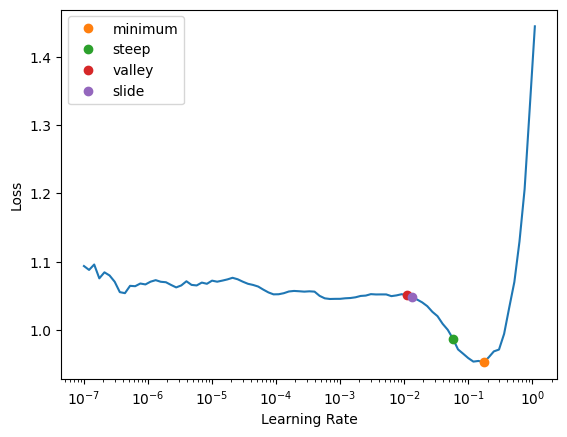

In [4]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print('intial learning rate=', lrs.valley)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.356332,0.335138,0.864411,0.062261,0.678713,03:34


Better model found at epoch 0 with valid_loss value: 0.33513787388801575.


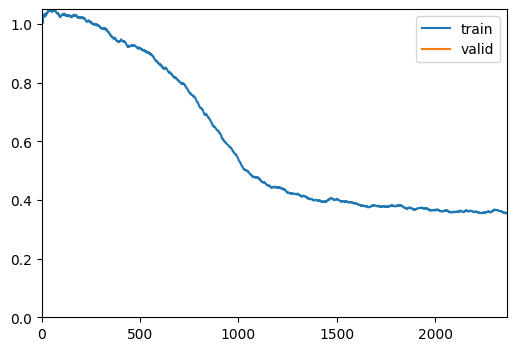

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.325882,0.307590,0.871601,0.146392,0.763775,03:33
1,0.298883,0.289402,0.877930,0.232055,0.801082,03:33
2,0.273739,0.271896,0.888107,0.351026,0.829404,03:34
3,0.245291,0.254697,0.895837,0.463948,0.855672,03:34
4,0.220869,0.241167,0.905656,0.541721,0.872053,03:34
5,0.192017,0.234407,0.912687,0.599594,0.883198,03:33
6,0.159888,0.224690,0.922281,0.649153,0.896794,03:34
7,0.130930,0.226527,0.926047,0.678304,0.902413,03:34
8,0.093964,0.245376,0.928875,0.697910,0.904446,03:34
9,0.081313,0.254456,0.931440,0.717064,0.903681,03:33


Better model found at epoch 0 with valid_loss value: 0.3075895309448242.


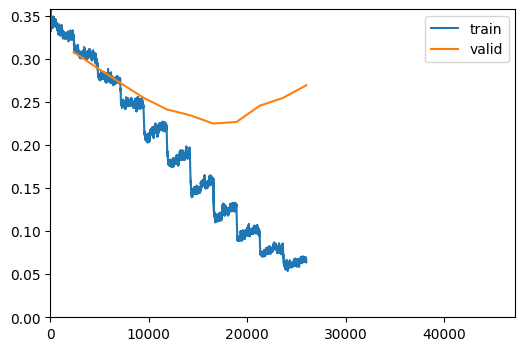

Better model found at epoch 1 with valid_loss value: 0.2894018292427063.
Better model found at epoch 2 with valid_loss value: 0.2718956172466278.
Better model found at epoch 3 with valid_loss value: 0.25469690561294556.
Better model found at epoch 4 with valid_loss value: 0.24116699397563934.
Better model found at epoch 5 with valid_loss value: 0.23440705239772797.
Better model found at epoch 6 with valid_loss value: 0.22469034790992737.
No improvement since epoch 6: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

Path('models/Resnet.pth')

In [5]:
learn.fine_tune(epochs=20, base_lr=1e-3)
learn.save('Resnet')

In [6]:
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True,vocab=class_names)),
                    splitter=RandomSplitter(valid_pct=0, seed=SEED),
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=item_transforms,
                   batch_tfms=batch_transforms
                  )
dls = dblock.dataloaders(test_df, bs=32, shuffle=False)


from sklearn.metrics import roc_auc_score
import gc

from sklearn.metrics import roc_auc_score
import torch
import gc

def get_roc_auc(model_arch,model_path):
    arch = model_arch
    learner = vision_learner(dls, arch, metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()])
    learner.model = torch.nn.DataParallel(learner.model)
    learner.load(model_path)
    learner.to('cuda')
    learner.freeze()
    preds, y_test = learner.get_preds(ds_idx=0)
    roc_auc = roc_auc_score(y_test, preds)

    scores=[]
    for i in range(0,len(class_names)):
        label_roc_auc_score=roc_auc_score(y_test[:,i],preds[:,i])
        scores.append(label_roc_auc_score)
    print('ROC_AUC_Labels:', list(zip(class_names,scores)))

#     print('AVERAGE', sum(scores)/len(scores))
    print(f' SCORE: {roc_auc}')
    acc_multi = accuracy_multi(preds, y_test)
    acc_multi = accuracy_multi(preds, y_test, thresh=0.6, sigmoid=False)

    print(f'Accuracy Multi: {acc_multi}')
    del learner
    gc.collect()
    return {
        'roc_auc': roc_auc,
        'preds': preds,
        'y_test': y_test
    }


densenet121_result= get_roc_auc(models.resnet50,'Resnet')



/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

ROC_AUC_Labels: [('Atelectasis', 0.6796238356804448), ('Consolidation', 0.6424587872815715), ('Effusion', 0.7827635605335074), ('Infiltration', 0.5650844084852317), ('Mass', 0.6346773764016734), ('Nodule', 0.596916304309032), ('Pneumothorax', 0.7811445712063145), ('Pleural_Thickening', 0.6350091116396468), ('Hernia', 0.682266849471066), ('Pneumonia', 0.5828153215831787), ('Fibrosis', 0.6727934286415818), ('Edema', 0.8167094286037019), ('Cardiomegaly', 0.8177184764621185), ('Emphysema', 0.8256662057001148)]
 SCORE: 0.693974833285656
Accuracy Multi: TensorBase(0.9273)
